## **Part-1**

In [1]:
import random
import docx
import csv
from docx.shared import Pt
from docx.enum.text import WD_PARAGRAPH_ALIGNMENT
from docx.shared import Mm
import win32gui
import time

In [2]:
import random
import docx
from docx.shared import Pt, Inches
from docx.enum.text import WD_PARAGRAPH_ALIGNMENT
from docx.enum.section import WD_ORIENT
from docx.oxml.ns import qn  # Correctly importing the namespace qualifier
import csv
import itertools

# Characters with indices
start_chars = ['ب']
mid_chars = ['ب', 'ج', 'س', 'ص', 'ط', 'ع', 'ف', 'ق', 'ک', 'ل', 'م', 'ن', 'ہ', 'ی']
end_chars = ['ا', 'ب', 'ج', 'د', 'ر', 'س', 'ص', 'ط', 'ع', 'ف', 'ق', 'ک', 'ل', 'م', 'ن', 'و', 'ھ', 'ہ', 'ی', 'ے']

# Creating index mappings
character_to_index = {char: i + 1 for i, char in enumerate(sorted(set(start_chars + mid_chars + end_chars)))}

def generate_urdu_words():
    indexed_words = []
    for length in range(1, 6):  # From 1 to 5 characters
        if length == 1:
            for s in start_chars:
                indexed_words.append((s, f"{length:02}_{character_to_index[s]:02}_none_none_none"))
        elif length == 2:
            for s in start_chars:
                for e in end_chars:
                    indexed_words.append((s + e, f"{length:02}_{character_to_index[s]:02}_{character_to_index[e]:02}_none_none"))
        else:
            for s in start_chars:
                for e in end_chars:
                    for combination in itertools.product(mid_chars, repeat=length-2):
                        word = s + ''.join(combination) + e
                        indexes = [character_to_index[s]] + [character_to_index[c] for c in combination] + [character_to_index[e]]
                        indexed_name = f"{length:02}_" + "_".join(f"{idx:02}" for idx in indexes)
                        indexed_words.append((word, indexed_name))
    return indexed_words

def create_word_document(filename, indexed_words):
    doc = docx.Document()
    section = doc.sections[0]
    section.page_height = Inches(11.7)  # A4 height
    section.page_width = Inches(8.3)  # A4 width
    section.top_margin = Inches(0.5)
    section.bottom_margin = Inches(0.5)
    section.left_margin = Inches(0.5)
    section.right_margin = Inches(0.5)
    section.orientation = WD_ORIENT.PORTRAIT
    # Adding columns to the section
    cols = section._sectPr.xpath('./w:cols')[0]
    cols.set(qn('w:num'), '4')  # Setting 4 columns

    # Setting the font
    style = doc.styles['Normal']
    font = style.font
    font.name = 'Noto Naskh Arabic'
    font.size = Pt(14)
    style.paragraph_format.line_spacing = Pt(14)  # Single line spacing

    for word, _ in indexed_words:
        doc.add_paragraph(word, style='Normal').alignment = WD_PARAGRAPH_ALIGNMENT.RIGHT
    
    doc.save(filename)

def create_csv_file(filename, indexed_words):
    with open(filename, 'w', newline='', encoding='utf-8') as csvfile:
        csvwriter = csv.writer(csvfile)
        for _, name in indexed_words:
            csvwriter.writerow([name])

# Generate words and save them
indexed_words = generate_urdu_words()
create_word_document('urdu_words.docx', indexed_words)
create_csv_file('indexed_urdu_words.csv', indexed_words)


In [4]:
import itertools
import os
import cv2
import numpy as np
from PIL import Image, ImageDraw, ImageFont, ImageOps
from arabic_reshaper import reshape
from bidi.algorithm import get_display

# Characters with indices
start_chars = ['ب']
mid_chars = ['ب', 'ج', 'س', 'ص', 'ط', 'ع', 'ف', 'ق', 'ک', 'ل', 'م', 'ن', 'ہ', 'ی']
end_chars = ['ا', 'ب', 'ج', 'د', 'ر', 'س', 'ص', 'ط', 'ع', 'ف', 'ق', 'ک', 'ل', 'م', 'ن', 'و', 'ھ', 'ہ', 'ی', 'ے']

# Creating index mappings
character_to_index = {char: i + 1 for i, char in enumerate(sorted(set(start_chars + mid_chars + end_chars)))}

def generate_urdu_words():
    indexed_words = []
    for length in range(1, 6):  # From 1 to 5 characters
        if length == 1:
            for s in start_chars:
                indexed_words.append((s, f"{length:02}_{character_to_index[s]:02}"))
        elif length == 2:
            for s in start_chars:
                for e in end_chars:
                    indexed_words.append((s + e, f"{length:02}_{character_to_index[s]:02}_{character_to_index[e]:02}"))
        else:
            for s in start_chars:
                for e in end_chars:
                    for combination in itertools.product(mid_chars, repeat=length-2):
                        word = s + ''.join(combination) + e
                        indexes = [character_to_index[s]] + [character_to_index[c] for c in combination] + [character_to_index[e]]
                        indexed_name = f"{length:02}_" + "_".join(f"{idx:02}" for idx in indexes)
                        indexed_words.append((word, indexed_name))
    return indexed_words

def apply_augmentations(image):
    # Convert PIL image to CV2 format
    image_cv = np.array(image)
    image_cv = image_cv[:, :, ::-1].copy()  # Convert RGB to BGR

    # Erosion
    kernel = np.ones((2,2), np.uint8)
    erosion = cv2.erode(image_cv, kernel, iterations = 1)

    # Dilation
    dilation = cv2.dilate(image_cv, kernel, iterations = 1)

    # Rotate
    center = (image_cv.shape[1] // 2, image_cv.shape[0] // 2)
    rotate_matrix = cv2.getRotationMatrix2D(center, 45, 1.0)
    rotation = cv2.warpAffine(image_cv, rotate_matrix, (image_cv.shape[1], image_cv.shape[0]))

    # Shear
    shear_matrix = np.float32([[1, 0.5, 0], [0, 1, 0]])
    shear = cv2.warpAffine(image_cv, shear_matrix, (image_cv.shape[1] + 30, image_cv.shape[0]))

    return {
        'erosion': erosion,
        'dilation': dilation,
        'rotation': rotation,
        'shear': shear
    }

# Function to save word images with proper reshaping for Urdu
def save_word_images(words, font_path):
    output_dir = 'urdu_word_images'
    os.makedirs(output_dir, exist_ok=True)

    font = ImageFont.truetype(font_path, size=32)

    for word, base_name in words:
        # Reshape and reorder the word for correct display
        reshaped_text = reshape(word)
        bidi_text = get_display(reshaped_text)

        image = Image.new('RGB', (200, 60), 'white')
        draw = ImageDraw.Draw(image)
        text_width, text_height = draw.textbbox((0, 0), bidi_text, font=font)[2:]
        draw.text(((200 - text_width) / 2, (60 - text_height) / 2), bidi_text, font=font, fill='black')

        # Save original image
        image.save(os.path.join(output_dir, f"{base_name}_none.png"))

        # Apply augmentations
        augmented_images = apply_augmentations(image)
        for aug_name, aug_image in augmented_images.items():
            Image.fromarray(aug_image[..., ::-1]).save(os.path.join(output_dir, f"{base_name}_{aug_name}.png"))

# Generate words and save as images
words = generate_urdu_words()
font_path = r'C:\Users\garda\Desktop\ML Assignment\Noto_Naskh_Arabic\NotoNaskhArabic-VariableFont_wght.ttf'
save_word_images(words, font_path)


In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Dense, LSTM, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
import numpy as np

# Define the CNN-RNN model architecture
def create_cnn_rnn_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    shape = pool2.shape
    rnn_input = Reshape(target_shape=(shape[1], shape[2] * shape[3]))(pool2)
    lstm = Bid
    irectional(LSTM(128, return_sequences=True))(rnn_input)
    lstm = Bidirectional(LSTM(64))(lstm)
    outputs = Dense(num_classes, activation='softmax')(lstm)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Function to load and preprocess images
def load_and_preprocess_images(image_dir, target_size=(128, 32)):
    image_files = [os.path.join(image_dir, fname) for fname in os.listdir(image_dir)]
    images = [img_to_array(load_img(img, color_mode="grayscale", target_size=target_size)) for img in image_files]
    images = np.array(images) / 255.0  # Normalize images
    labels = [os.path.splitext(os.path.basename(img))[0] for img in image_files]
    return images, labels

# Function to convert labels to integers and then to categorical data
def process_labels(labels):
    label_to_index = {label: idx for idx, label in enumerate(sorted(set(labels)))}
    labels_int = [label_to_index[label] for label in labels]
    labels_cat = to_categorical(labels_int, num_classes=len(label_to_index))
    return labels_cat, len(label_to_index)

# Main function to execute training
def main():
    image_dir = 'path_to_urdu_images'
    images, labels = load_and_preprocess_images(image_dir)
    labels, num_classes = process_labels(labels)
    
    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.1, random_state=42)
    
    model = create_cnn_rnn_model(X_train.shape[1:], num_classes)
    model.summary()

    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)
    model.evaluate(X_test, y_test)

if __name__ == "__main__":
    main()


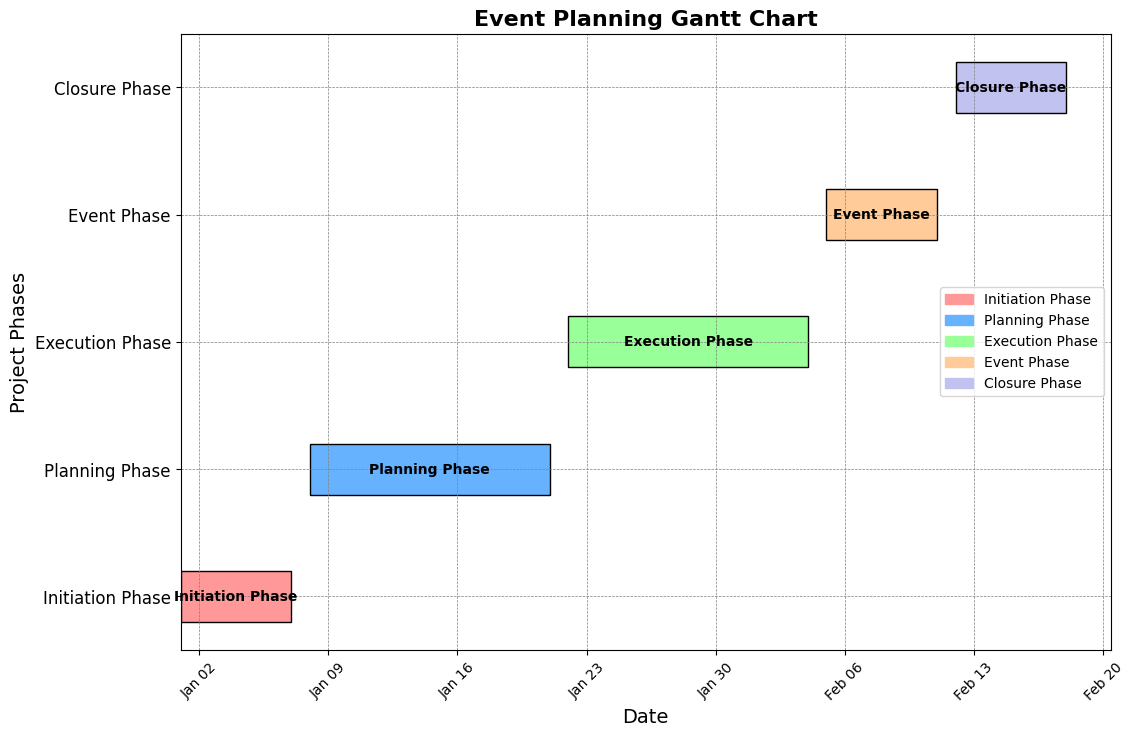

In [5]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import matplotlib.patches as mpatches

# Define the project phases and their durations
phases = [
    ("Initiation Phase", "2024-05-15", "2024-05-22"),
    ("Planning Phase", "2024-05-23", "2024-05-30"),
    ("Execution Phase", "2024-05-01", "2024-05-08"),
    ("Event Phase", "2024-02-09", "2024-02-16"),
    ("Closure Phase", "2024-02-12", "2024-02-18"),
]

# Convert date strings to datetime objects
def str_to_date(date_str):
    return datetime.strptime(date_str, "%Y-%m-%d")

phases = [(phase, str_to_date(start), str_to_date(end)) for phase, start, end in phases]

# Create a figure and axis for the Gantt chart
fig, ax = plt.subplots(figsize=(12, 8))

# Define colors for each phase
colors = ['#FF9999', '#66B2FF', '#99FF99', '#FFCC99', '#C2C2F0']

# Plot each phase with more customization
for i, (phase, start, end) in enumerate(phases):
    ax.barh(phase, (end - start).days, left=start, height=0.4, align='center', color=colors[i], edgecolor='black')
    ax.text(start + (end - start) / 2, i, phase, va='center', ha='center', color='black', fontsize=10, weight='bold')

# Format the x-axis to show dates
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=12)

# Add labels and title
plt.xlabel('Date', fontsize=14)
plt.ylabel('Project Phases', fontsize=14)
plt.title('Event Planning Gantt Chart', fontsize=16, weight='bold')

# Add grid lines for better readability
ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='grey')

# Add legend
legend_patches = [mpatches.Patch(color=colors[i], label=phases[i][0]) for i in range(len(phases))]
ax.legend(handles=legend_patches, loc='center right', fontsize=10)

# Adjust layout
# plt.tight_layout()

# Display the Gantt chart
plt.show()
